## Generative Modeling생성 모델링

#### Discriminative Modeling판별 모델_입력된 데이터셋을 특정 기준에 따라 분류하거나, 특정 값을 맞추는 모델

#### Generative Modeling생성 모델_학습한 데이터셋과 비슷하면서도 기존에는 없던 새로운 데이터셋을 생성하는 모델

### Generative Modeling_①Pix2Pix

Input Image이미지와 Ground Truth실제 이미지를 쌍으로 학습을 진행하고

Input Image를 입력받으면, Predicted Image를 출력하게 된다. Ground Truth와 얼마나 비슷한지 평가하며 실제 같은 결과물을 만들게 된다. 


### Generative Modeling_②CycleGAN

실사 이미지를 그림으로, 그림을 실사 이미지로 변환이 가능

Pix2Pix와 달리 paired data를 필요로 하지 않기 때문에, 데이터를 구하기 쉽고 label에 anotation비용이 필요 없어진다.


### Generative Modeling_③Neural Style Transfer

Base Image에서 content를, Style Image에서 Style을 추출해서 결과물을 생성한다.

In [27]:
# 라이브러리 호출

import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow", tf.__version__)

tensorflow 2.6.0


In [28]:
# 데이터 호출
# 각 이미지가 어떤 카테고리인지 나타내는 label이 필요없기 때문에, y_train / y_test에 해당하는 데이터를 언더스코어 처리.

fashion_mnist = tf.keras.datasets.fashion_mnist

(train_x, _), (test_x, _) = fashion_mnist.load_data() # 분류문제에서 사용할 label데이터가 필요하지 않기 때문에, 해당 데이터를 언더스코어 처리

In [29]:
# 데이터 확인
# 28 x 28의 흑백이미지로, 각 픽셀은 0~255 사이의 정수값으로 표현

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 255
min pixel: 0


In [30]:
# 정규화
# 각 픽셀은 0 ~ 255인데, -1 ~ 1로 정규화시켜서 사용하도록, 중간값을 0으로 맞춘다.(127.5를 빼고 127.5로 나눠주기)

train_x = (train_x - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [31]:
# 데이터셋의 shape 확인

train_x.shape

(60000, 28, 28)

In [32]:
# 입력되는 이미지데이터의 채널 수에 대한 차원을 추가(grayscale은 1개의 채널, color이미지는 RGB 3개의 채널)
# train_x.shape[0]은 튜플(train_x데이터)의 1번째 요소로 첫 번째 차원의 크기(데이터의 수)로
# (이미지의 개수가 가변적일 수 있기 때문에 )train_x.shape[0]으로 표시함으로써 데이터셋의 크기와 상관없이 배열을 재구성할 수 있다.

train_x = train_x.reshape(train_x.shape[0], 28, 28, 1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

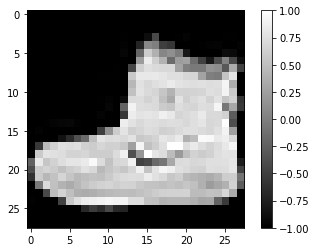

In [33]:
# 첫 번째 데이터 확인

plt.imshow(train_x[0].reshape(28, 28), cmap='gray')
plt.colorbar()
plt.show()

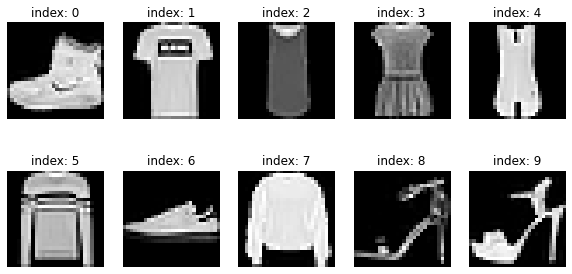

In [34]:
# for문을 이용해 데이터 추가 확인

plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1) #(row, column, index)
    plt.imshow(train_x[i].reshape(28, 28), cmap='gray')
    plt.title(f'index: {i}')
    plt.axis('off')
plt.show()

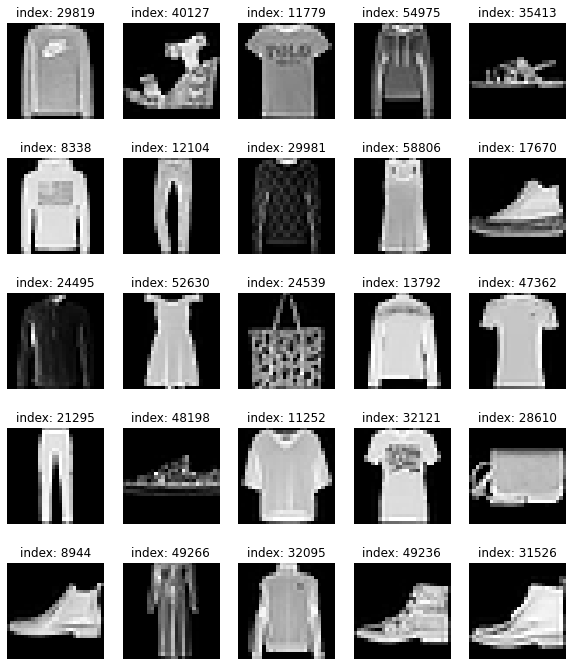

In [35]:
# 데이터 25개를 랜덤하게 뽑아서 확인해보기

plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 60000)
    plt.imshow(train_x[random_index].reshape(28, 28), cmap='gray')
    plt.title(f'index: {random_index}')
    plt.axis('off')

plt.show()

#### 미니 배치 학습

모델이 한 번에 학습하는 데이터의 양이 많아지면 메모리활용면에서 비효율, 연산에 들어가는 시간도 길어지기 때문에 BATCH_SIZE를 이용해서 적절하게 설정

In [36]:
# tensorflow의 Dataset 준비

BUFFER_SIZE = 60000 # 전체에 해당하는 60,000을 섞을 예정
BATCH_SIZE = 256    # 모델이 한 번에 학습하는 데이터의 양

In [37]:
# from_tensor_slices() - 리스트, 넘파이, 텐서플로우의 텐서 자료형에서 데이터셋을 만들기
# train_x라는 넘파이 배열형 자료를 섞고, 배치 사이즈에 따라 나눈다
# 데이터가 잘 섞이도록 버퍼 사이즈를 전체 데이터 사이즈와 같거나 크게 설정하는 것이 좋다.

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Generative Adversarial Network

#### Generator생성자는 아무 의미 없는 랜덤 노이즈로부터 신경망에서의 연산을 통해 이미지 형상의 벡터를 생성

#### Discriminator판별자는 진짜 이미지와 생성자가 만들어낸 이미지를 입력받아 Real인지 Fake인지를 판단한 실숫값을 출력

#### 생성자와 판별자가 서로 경쟁하며 성장

### Generator생성자 구현

In [38]:
# Keras Sequential API를 활용해서 Deep Convolutuinal GAN 모델 구현하기
# 생성자를 생성하도록, make_generator_model이라는 함수를 생성
# Conv2DTranspose레이업는 Conv2D와 반대로 이미지 사이즈를 넓혀주는 층
# 3번의 Conv2DTranspose 레이어를 이용해 (7, 7, 256) -> (14, 14, 64) -> (28, 28, 1)로, 준비했던 데이터셋과 형상을 통일

def make_generator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization()) # 가중치가 폭발하지 않도록 가중치 값을 정규화
    model.add(layers.LeakyReLU())
    
    # Second:Reshape layer
    model.add(layers.Reshape((7, 7, 256)))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                    activation='tanh')) # [-1, 1] 값으로 픽셀값을 정규화시킨 데이터셋과 동일한 활성화함수 설정.
    
    return model

In [39]:
# 변수 생성

generator = make_generator_model()

# summary 출력

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 12544)             1254400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 12544)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 7, 7, 128)        

In [40]:
# tf.random.normal - 노이즈 벡터 생성하기

noise = tf.random.normal([1, 100])

In [41]:
# 결과 이미지 생성하기(생성자 모델에 입력값으로 노이즈를 넣고 모델을 호출)
# 학습하는 중이 아니기 때문에 training=False로 설정
# Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르다.

generated_image = generator(noise, training=False)
generated_image.shape

# batch_size=1이고, (28, 28, 1)사이즈 이미지가 생성된 것을 확인할 수 있다.

TensorShape([1, 28, 28, 1])

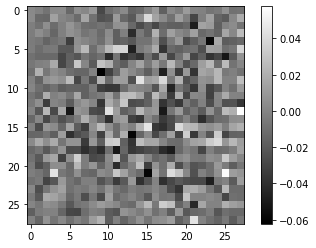

In [42]:
# 이미지를 시각화
# matplotlib 라이브러리는 2차원 이미지만 출력할 수 있기 때문에, 0번째와 3번째 축의 인덱스를 0으로 설정, (28, 28)shape의 이미지를 꺼낸다.

plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.colorbar()
plt.show()

### Discriminator판별자 구현

In [43]:
# 판별자 설계하기
# (28, 28, 1)크기의 이미지가 입력되면, 진짜라고 판단하는 정도를 나타내는 하나의 숫자로 출력된다.
# Conv2D층을 거치면서(28, 28, 1) -> (14, 14, 64) -> (7, 7, 128)로 줄어든다.
# Flatten층을 통과하면서 7*7*128=6272, (1, 6272)형상의 벡터로 변환된다.(생성자의 Reshape층에서 1차원벡터를 3차원으로 변환했던 것과 반대 역할)
# 1차원 벡터로 변환한 후에는 Dense layer를 거쳐 단 하나의 값을 출력한다.

def make_discriminator_model():
    
    # Start
    model = tf.keras.Sequential()
    
    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    
    # Fourth: Dense Layer
    model.add(layers.Dense(1))
    
    return model    

In [44]:
# 판별 모델의 변수 이름 생성
# 구조 확인

discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)             

In [45]:
# 생성한 fake_image(noise_vector)를 판별자에 입력시켜서 결과 확인

decision = discriminator(generated_image, training=False)
decision

# 텐서플로우의 텐서 형태로 출력을 확인

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00312665]], dtype=float32)>

### 학습을 위한 세팅_ 손실함수와 최적화함수

#### GAN은 손실함수로 Cross Entropy를 사용하는데, 판별자는 진짜인지 가짜인지 2개 클래스 간 분류를 위해서 binary cross entropy를 사용

#### 1. 생성자는, 판별자가 fake_image에 대해 판별한 값 D(fake_image)값이 1에 가깝게

#### 2. 판별자는, real_image에 대한 판별값 D(real_image)은 1(진짜), D(fake_image)는 0에 가깝게

#### 결국 손실함수에 들어가는 값은 모두 판별자의 판별값이 된다.

#### 1. Cross Entropy를 계산하기 위해 입력할 값은 판별자가 판별한 값인데, 판별자 모델의 마지막 Layer에는 값을 정규화시키는 활성화함수가 없는 상태로, 판별자가 출력하는 값이 범위가 정해지지 않아서 모든 실숫값을 가지게 된다.

#### 2. tf.keras.losses의 BinaryCrossEntropy 클래스는 input값이 0-1 사이에 분포하는 확률값으로 가정하기 때문에, BinaryCrossEntropy에 입력된 값을 함수 내부에서 sigmoid함수를 통해 0-1 사이의 값으로 정규화 한 후 계산하도록, from_logits을 True로 설정

#### tf.ones_like()와 tf.zeros_like() 함수를 활용해서 1과 0으로 표현, 비교할 수 있다.

#### generator_loss , discriminator_loss, discriminator accuracy 세팅

#### 판별자의 fake accuracy가 1(생성자가 만들어낸 fake output이 가짜라는 것을 잘 잡아낸다는 의미)로 나온다는 것은 생성자가 판별자를 속이고 있지 못하다는 의미이다. fake accuracy, real accuracy 모두 처음에는 1이었다가, 0.5에 수렴하는 것이 가장 이상적이다.

In [46]:
# cross entropy에 들어갈 값을 설정.

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [47]:
# tf.ones_like(), tf.zeros_like() 를 활용해서
# fake_output과 real_output을 각각 1또는 0에 비교할 수 있다.

vector = [[1, 2, 3],
         [4, 5, 6]]

tf.ones_like(vector)

<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
array([[1, 1, 1],
       [1, 1, 1]], dtype=int32)>

In [48]:
# generator_loss
# cross_entropy(tf.ones_like(fake_output), fake_output) 값은, fake_output이 1에 가까울수록(real image) 작은 값을 가진다.

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [49]:
# discriminator_loss
# real_output은 1에 가깝게 fake_output은 0에 가까워지기를 바라므로
# real_output은 1로 채워진 벡터와, fake_output은 0으로 채워진 벡터와 비교한다.

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.xeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [50]:
# discriminator accuracy
# tf.math.greater_equal(real_output, tf.constant([0.5])) - real_output의 각 원소가 0.5이상인지 True, False로 판별
# tf.cast((결과A), tf.float32) - 결과A가 True이면 1.0, False이면 0.0으로 변환
# tf.reduce_mean(결과B) - 결과B를 평균내어 이번 배치의 accuracy를 계산

def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [51]:
# Optimizer최적화함수
# 생성자와 판별자는 따로 학습을 진행하는 개별 네트워크이기 때문에 optimizer를 별개로 생성해야 한다.
# learning rate는 0.0001로 설정, 학습 품질을 올리고 싶다면 변경을 시도해 볼 것.

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [52]:
# 학습이 어떻게 진행되고 있는지 확인하기 위해 생성자가 만든 샘플 확인
# 100차원의 노이즈를 총 16개, (16, 100)형상의 벡터를 만들어둔다.

noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

## PROJECT_CIFAR-10 이미지 데이터셋을 이용해서 생성하기

#### [-1, 1]로 정규화시킨 목적은 무엇인가? (생성자 모델링에서) 나중에 tanh activation function 사용할 걸 염두해서?

#### 6-9 Q1. '노이즈 벡터'는 무엇인가? 생성 모델에서 무작위성과 다양성을 부여하고, 다양한 샘플을 생성하는 데 사용되는 벡터

#### Batch Normalization 레이어는 훈련 시기와 추론(infernce) 시기의 행동이 다르다?

배치 정규화는 훈련시에는 효과적이지만 추론 시에는 효과적이지 않을 수 있다. 배치 정규화가 각 층의 입력값을 정규화하기 때문에 추론 시에는 입력값이 정규화되지 않은 신경망의 출력값과 차이가 발생할 수 있기 때문. 이러한 문제를 해결하기 위해 배치 정규화의 가중치를 고정하거나 배치 정규화를 사용하지 않는 방법으로, 추론 시 행동을 변경하는 방법이 있다. 배치 정규화는 신경망의 학습 성능을 향상시키는데 효과적인 기법이지만, 추론 시 행동을 변경해야 할 수도 있다.('지금은 훈련중이 아니기 때문...')

#### 그렇다면 batchnormalization을 하게되는 훈련 시기는 언제이고, '추론 시기는 언제인가?' 행동이 어떻게 다르다는 것인가?

딥러닝 모델이 훈련 데이터에 대한 패턴을 학습하고 이 모델을 사용하여 새로운 데이터에 대한 예측을 추론하는데, 훈련 데이터에 대한 예측은 이미 알려진 정답을 가지고 있기 때문에 모델이 얼마나 정확하게 예측하는지 평가할 수 있다. 하지만 새로운 데이터에 대한 예측은 정답을 알 수 없기 때문에 이를 '추론'이라고 표현한다.

#### 6-11 '생성할 샘플은 매번 같은 노이즈로 생성해야 그에 대한 진전 과정을 확인할 수 있으므로, 고정된 seed 노이즈로 만들어두어야 한다'?